<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [4]:
'''
Analyzed the total travel distance, average speed (cm/min), percentage of time(frames) in the center of OF

Ongoning: analysis the difference in terms of gender and genetic abnormality (5xFAD model vs w.t.)
'''

In [8]:
nBPs = 1 # No. of body parts
hN = 8 #
BoxL = 40

hBin = BoxL/hN

In [55]:
import pandas as pd
import numpy as np
import os, sys, re
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# import math




def load_prepared_data(path='/Users/arthur/Behavior/filter_csv_name_adj.csv'):
    # 1. Prepared video info
    data = pd.read_csv(path)
    # data.head()
    data = data.set_index('video')
    data['travel_distance_cm'] = 0
    data['average_speed_cm_min'] = 0
    data['per_center'] = 0
    return data

# import cv2
#新视频分析
def get_video_dur(dir_name):
    dur_dic = {}
    for root, dirs, files in os.walk(dir_name, topdown=False):
        for filename in files:
            cap = cv2.VideoCapture(dir_name + "\\" + filename)
            if cap.isOpened():
                rate = cap.get(5)
                frame_num = cap.get(7)
                duration = frame_num / rate
                dur_dic[filename] = duration # Unit: second

    return dur_dic


def get_video_info(video,data):
#     csvdata = pd.read_csv(df)
#     csvdata = csvdata.set_index('video')
    csvls = data.index.values.tolist()
#     for each in csvls:
#     print(csvdata.head())
    return data.loc[video][:3]


# 查找所有过滤后的DLC数据 ; 返回之前选定的视频对应的filtered.csv文件绝对路径
def read_filtered_csv(dir_name, videoname):
    csv_ls = []
    for root, dirs, files in os.walk(dir_name, topdown=False):
        #         print(f'name: {files}\n, root:{root}\n, dirs: {dirs}')
        for filename in files:
#             print(filename)
            if 'filtered.csv' in filename:
                #                 print(f'name: {filename}\n, root:{root}\n,')
                csv_ls.append(root + filename)
#     print(csv_ls)
    try:
        filtered_path = list(filter(lambda x: videoname in x, csv_ls))[0]  # 若存在多个视频滤过数据，默认第一个
        return filtered_path
    except:
        return (-1)

    

def process(filtered_path, dur, nBPs = nBPs):
    global Time, fLs
    T = pd.read_csv(filtered_path)
    # DataFrame结构调整
    T = T.set_index('scorer')
    T = T.drop(['bodyparts', 'coords'])
    # 获取csv视频总帧数 fLs
    fLs = T.index.values.tolist()

    t_reso = dur / len(fLs)

    Time = np.arange(t_reso, dur, t_reso)


    # 写入3D array
    cData = np.zeros((nBPs, len(fLs), 2))  # 注意传参顺序
    for i in range(0, nBPs):  # 0/3/6/9
        MyBid = 3 * i
        print(i)
        cData[i, :, 0] = T.iloc[:, MyBid]
        cData[i, :, 0] /= CalX
        cData[i, :, 1] = T.iloc[:, MyBid + 1]
        cData[i, :, 1] /= CalY
    return cData,fLs, Time

def cal_speed_dis(cData, ratiox, ratioy,dur,nBPs = 1):

    SpeedVect = np.zeros((nBPs, 1))
    sns.set_style('whitegrid')
    for i in range(nBPs):
        MyX = np.squeeze(cData[i, :, 0])
        MyY = np.squeeze(cData[i, :, 1])
        MySque = pd.DataFrame(np.hstack((MyX.reshape(-1, 1), MyY.reshape(-1, 1))), columns=['x', 'y'])
        #     print(MySque.head())
        # Distance 勾股距离
        Dist = sum(np.sqrt((abs(np.diff(MyX)*ratiox) ** 2) + abs((np.diff(MyY)*ratioy) ** 2))) # pixel * ratio = cm
        Sped = Dist / (dur / 60) # cm/min
        SpeedVect[i] = Sped
        data.loc[videoname, 'average_speed_cm_min'] = Sped
        # print(Dist, '---', Sped)
        # print(SpeedVect)
        # print(f'No.{i + 1} body part : \n', MySque)

        # Plotting

        jointp = sns.JointGrid(data=MySque, x='x', y='y')
        jointp.plot_joint(sns.scatterplot)
        jointp.plot_marginals(sns.kdeplot, fill=True)
        jointp.set_axis_labels(xlabel='X axis', ylabel='Y axis', fontsize=10)
        plt.savefig(f'./joint_plot_dis_{videoname}_{i}.svg', dpi=600, bbox_inches='tight')  # tight 无边框
        # plt.show()



def cal_cumsum_dist(cData,ratiox,ratioy,Time, nBPs=1):
    '''累积移动距离'''
    fig, ax = plt.subplots()
    for i in range(nBPs):
        deltadist = np.sqrt(abs((np.diff(np.squeeze(cData[i, :, 0]))* ratiox) ** 2) + abs((
            np.diff(np.squeeze(cData[i, :, 1]))* ratioy) ** 2))

        CumDist = np.cumsum(deltadist)
        #     print(CumDist.shape)

        try:
            ax.plot((Time[1:] / 60), CumDist, label=f'No. {i + 1} body part') # Time[1:] or Time[:]
        except:
            ax.plot((Time[:] / 60), CumDist, label=f'No. {i + 1} body part') 

    #     print(CumDist)
    ax.set_xlabel('Time (min)')  # 设置x轴名称 x label
    ax.set_ylabel('Travel Distance (cm)')  # 设置y轴名称 y label
    ax.set_title('Plotting of Travel Distance based on diff BP')  # 设置图名为Simple Plot
    ax.legend()  # 自动检测要在图例中显示的元素，并显示
    plt.savefig(f'./Travel_Distance_{videoname}.svg', dpi=600, bbox_inches='tight')  # tight 无边框
    trav_dis = CumDist[-1]
    # data['travel_distance_cm'].loc[videoname] = trav_dis
    data.loc[videoname,'travel_distance_cm'] = trav_dis

def edge_prefer(fLs, cData, EdgeWidth=5, BoxL=BoxL):
    MyBP = 1
    BoxSize = BoxL
    MyXY = np.squeeze(cData[MyBP - 1, :, :])
    # MyXY.shape
    MyXY = MyXY.tolist()
    NumFrame = np.squeeze(cData[MyBP - 1, :, :]).shape[0]
    # 计算小鼠在非边缘的帧数比例 Q: How close it get
    ls_center = []
    for i in range(NumFrame):
        if MyXY[i][0] >= EdgeWidth and MyXY[i][0] <= BoxSize - EdgeWidth and MyXY[i][1] >= EdgeWidth and MyXY[i][1] <= BoxSize - EdgeWidth:
            ls_center.append(i)

    # ls_center  # 位于中心的帧索引列表
    per_center_val = len(ls_center) / len(fLs)
    # data['per_center'].loc[videoname] = per_center_val
    data.loc[videoname, 'per_center'] = per_center_val
    return data


In [37]:
data = load_prepared_data() #执行一次
filels= data.index.values.tolist()

In [26]:
filels

['FAD01_OF',
 'FAD02_OF',
 'FAD03_OF',
 'FAD04_OF',
 'FAD09_remapped',
 'FAD10_remapped',
 'FAD11_remapped',
 'FAD12_remapped',
 'FAD13_remapped',
 'FAD15_remapped',
 'FAD16_remapped',
 'FAD17_OF',
 'FAD18_OF',
 'FAD19_OF',
 'FAD20_OF',
 'TL M FAD-_OF',
 'TR M FAD+_OF',
 'TL F FAD-_OF',
 'TR F FAD+_OF']

In [32]:

print(data)

                       tl         br   length  travel_distance_cm  \
video                                                               
FAD01_OF        [103, 86]  [398,407]  1357.08                   0   
FAD02_OF          [24,69]  [324,401]  1357.08                   0   
FAD03_OF          [22,76]  [319,405]  1194.64                   0   
FAD04_OF          [92,77]  [387,396]  1194.64                   0   
FAD09_remapped   [102,98]  [395,384]  1192.20                   0   
FAD10_remapped    [18,87]  [309,384]  1192.20                   0   
FAD11_remapped    [96,27]  [395,309]  1192.20                   0   
FAD12_remapped    [16,25]  [298,302]  1192.20                   0   
FAD13_remapped   [102,92]  [389,387]  1211.26                   0   
FAD15_remapped    [98,20]  [394,200]  1211.26                   0   
FAD16_remapped    [14,18]  [298,293]  1211.26                   0   
FAD17_OF          [90,96]  [369,396]  1189.64                   0   
FAD18_OF           [8,97]  [302,39

In [46]:
filels

['FAD01_OF',
 'FAD02_OF',
 'FAD03_OF',
 'FAD04_OF',
 'FAD09_remapped',
 'FAD10_remapped',
 'FAD11_remapped',
 'FAD12_remapped',
 'FAD13_remapped',
 'FAD15_remapped',
 'FAD16_remapped',
 'FAD17_OF',
 'FAD18_OF',
 'FAD19_OF',
 'FAD20_OF',
 'TL M FAD-_OF',
 'TR M FAD+_OF',
 'TL F FAD-_OF',
 'TR F FAD+_OF']

0
output ==                        tl         br   length  travel_distance_cm  \
video                                                               
FAD01_OF        [103, 86]  [398,407]  1357.08       217910.165483   
FAD02_OF          [24,69]  [324,401]  1357.08       107945.059844   
FAD03_OF          [22,76]  [319,405]  1194.64       138366.769781   
FAD04_OF          [92,77]  [387,396]  1194.64       135215.009788   
FAD09_remapped   [102,98]  [395,384]  1192.20       118461.778588   

                average_speed_cm_min  per_center  
video                                             
FAD01_OF                 9634.369329    0.365425  
FAD02_OF                 4772.528952    0.509467  
FAD03_OF                 6949.379049    0.443079  
FAD04_OF                 6791.083998    0.437655  
FAD09_remapped           5961.840895    0.320517  
0
output ==                        tl         br   length  travel_distance_cm  \
video                                                             

0


/Users/arthur/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:1670: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(height, height))


output ==                        tl         br   length  travel_distance_cm  \
video                                                               
FAD01_OF        [103, 86]  [398,407]  1357.08       217910.165483   
FAD02_OF          [24,69]  [324,401]  1357.08       107945.059844   
FAD03_OF          [22,76]  [319,405]  1194.64       138366.769781   
FAD04_OF          [92,77]  [387,396]  1194.64       135215.009788   
FAD09_remapped   [102,98]  [395,384]  1192.20       118461.778588   

                average_speed_cm_min  per_center  
video                                             
FAD01_OF                 9634.369329    0.365425  
FAD02_OF                 4772.528952    0.509467  
FAD03_OF                 6949.379049    0.443079  
FAD04_OF                 6791.083998    0.437655  
FAD09_remapped           5961.840895    0.320517  
0
output ==                        tl         br   length  travel_distance_cm  \
video                                                               

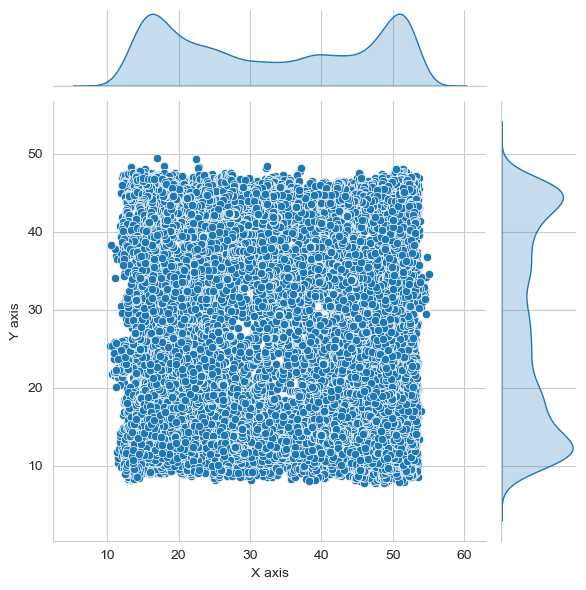

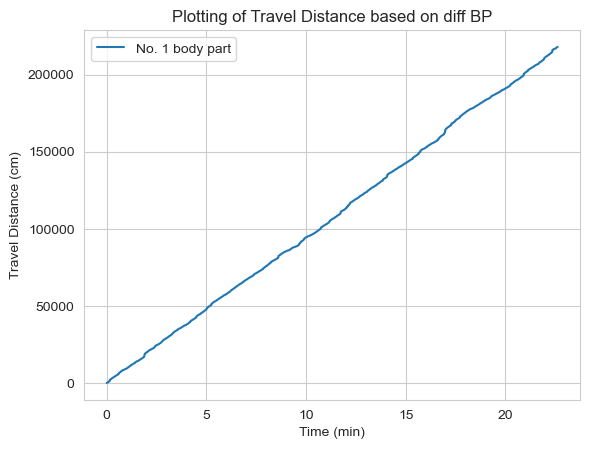

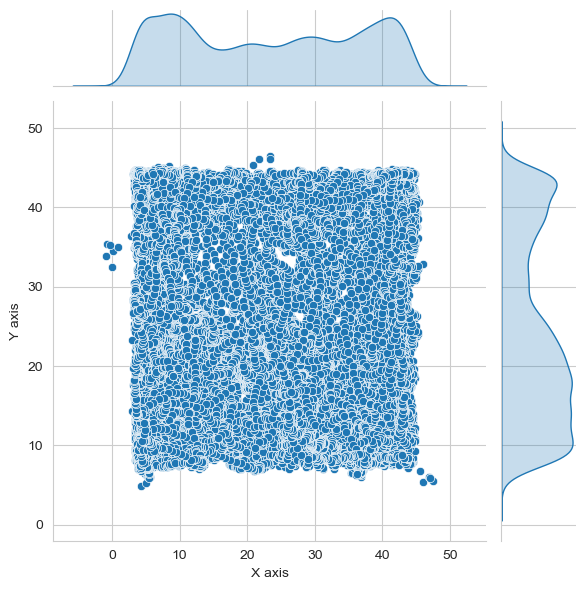

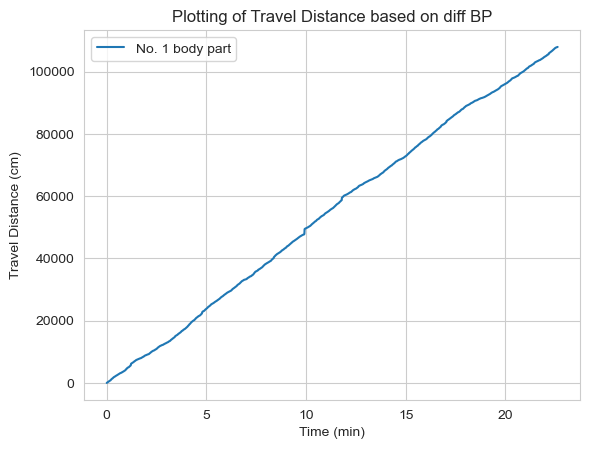

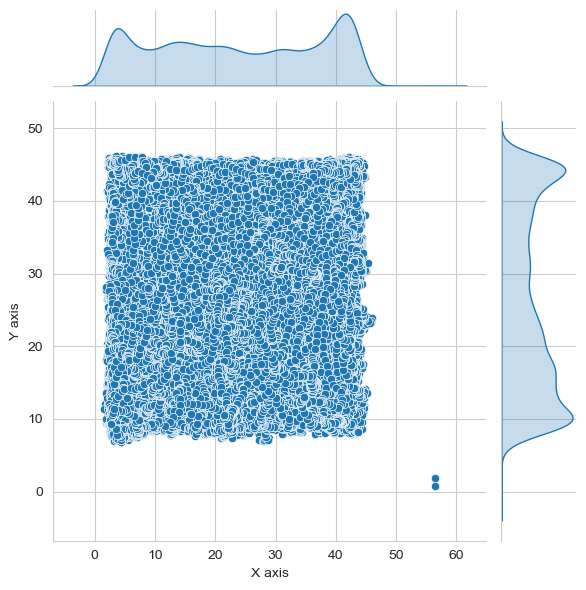

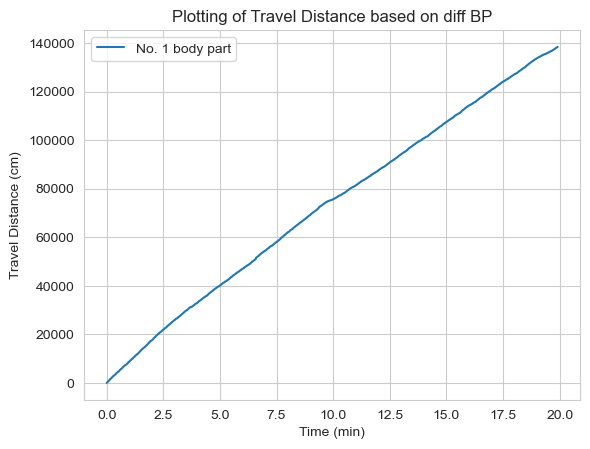

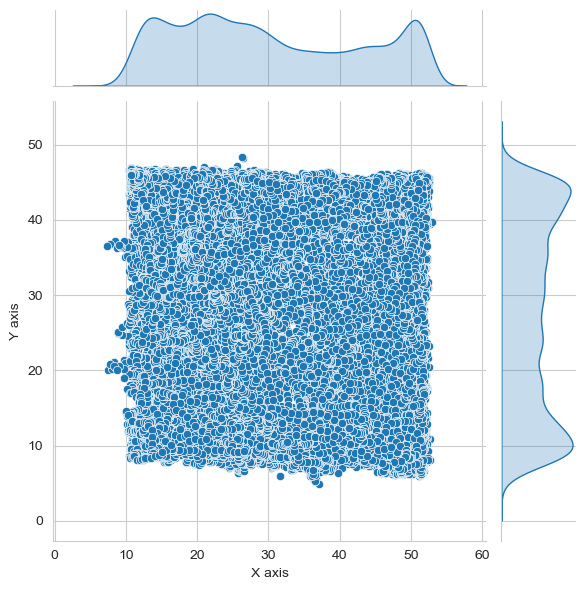

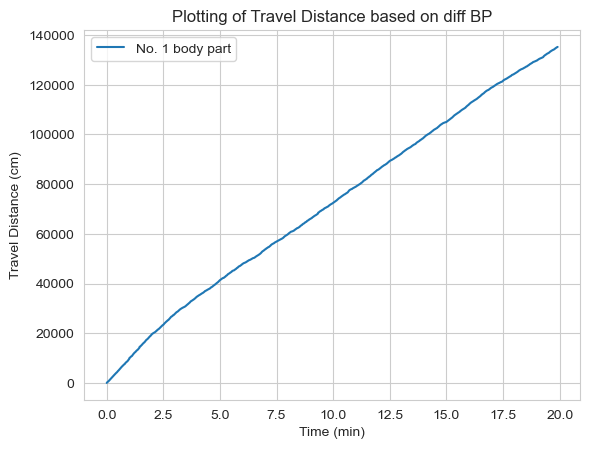

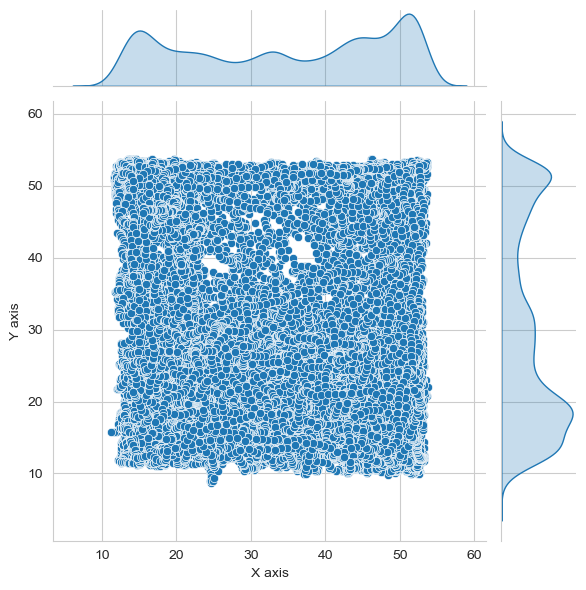

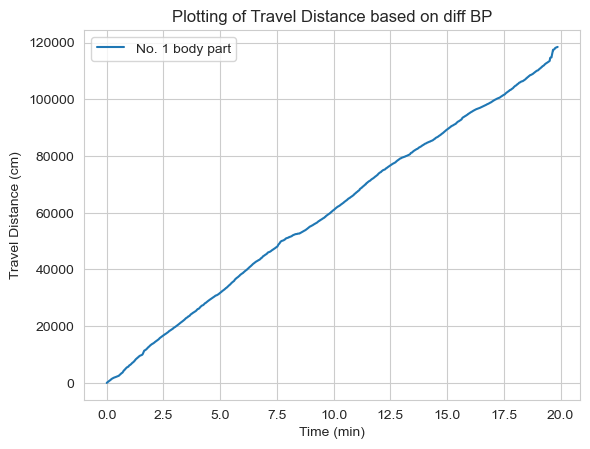

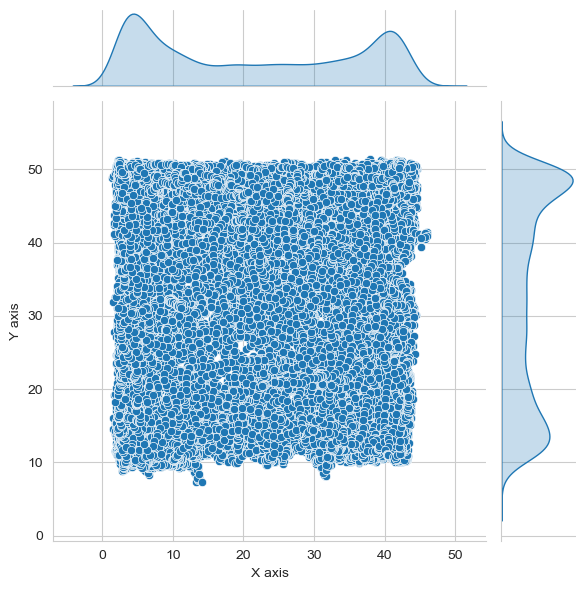

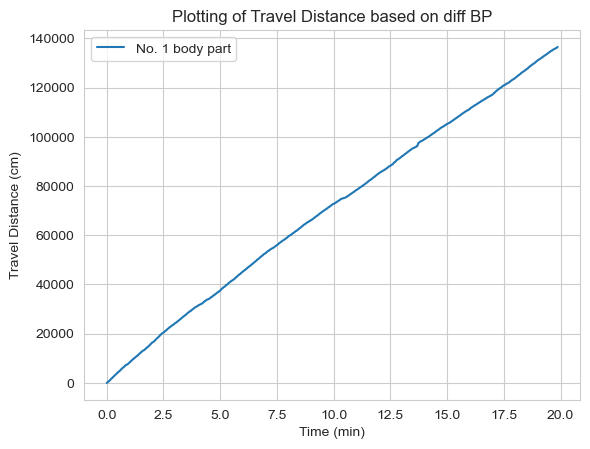

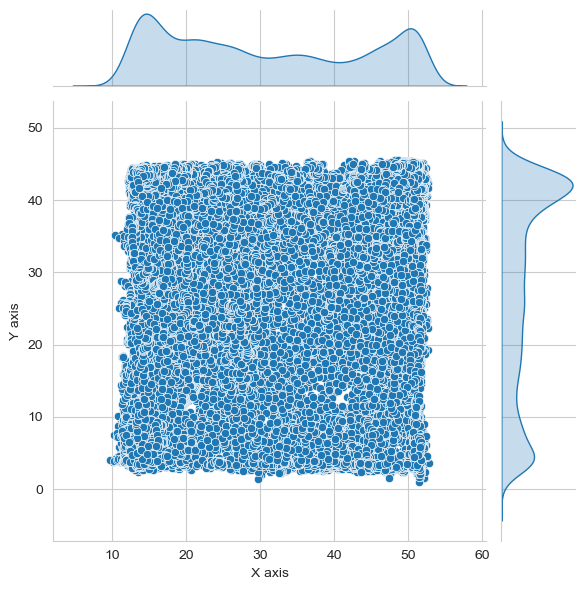

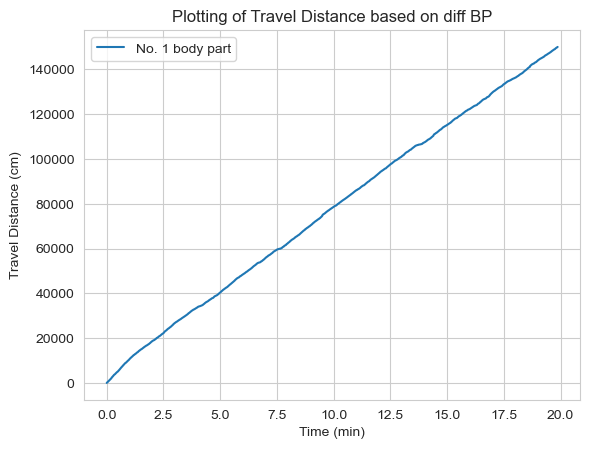

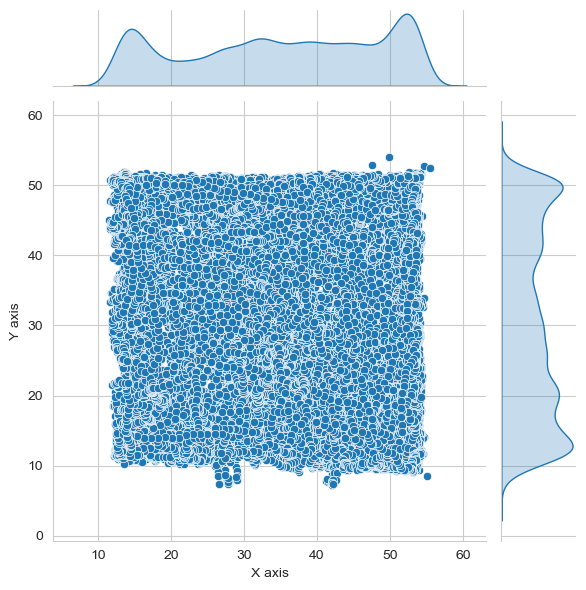

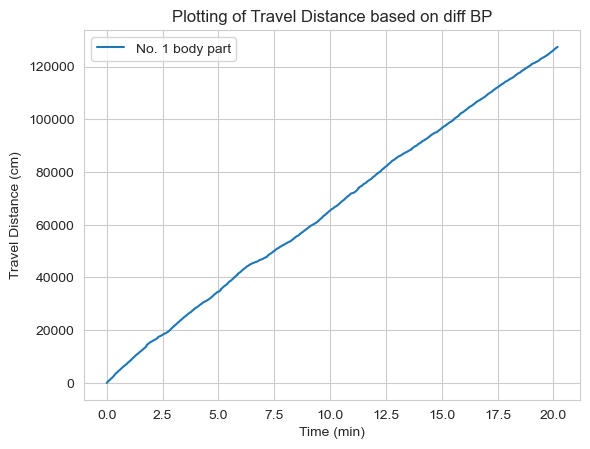

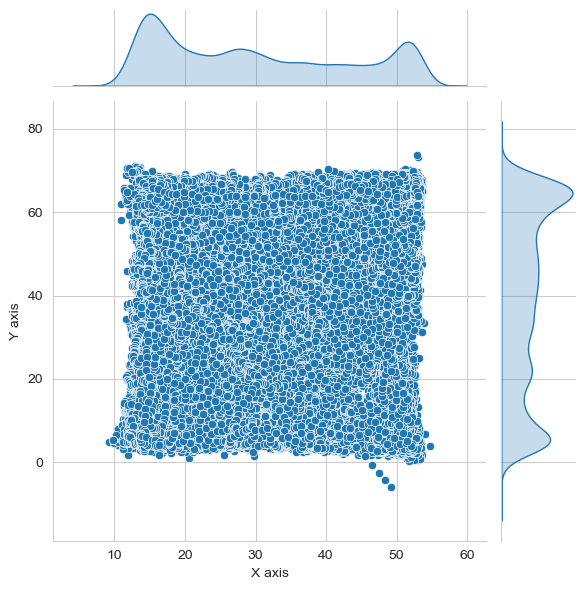

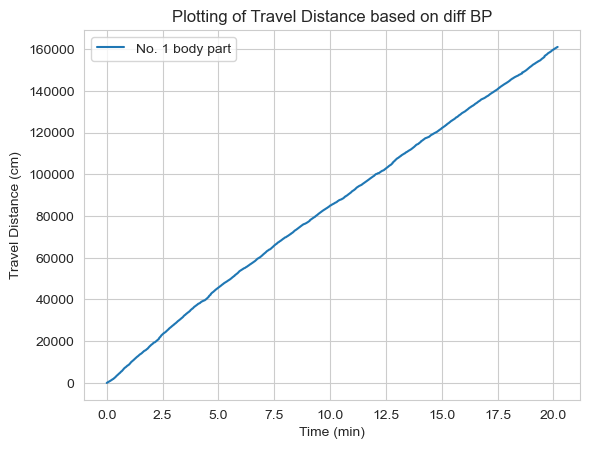

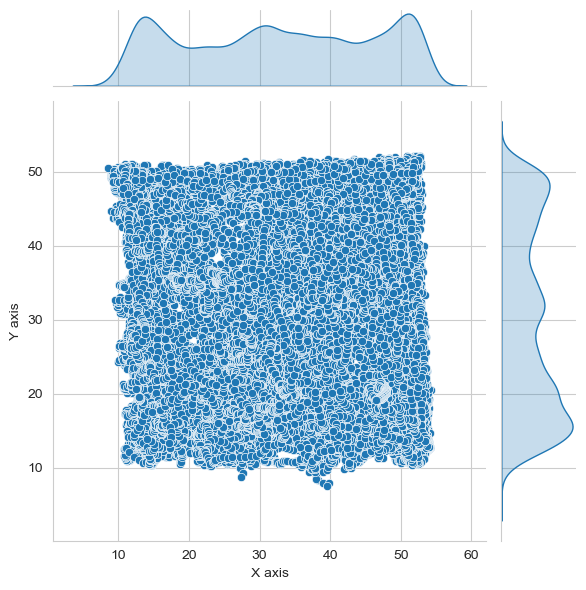

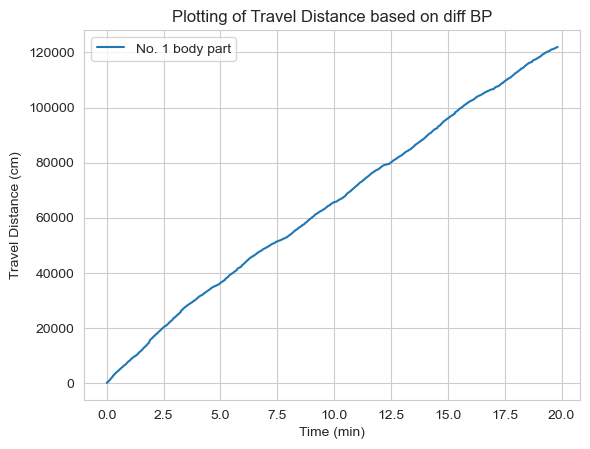

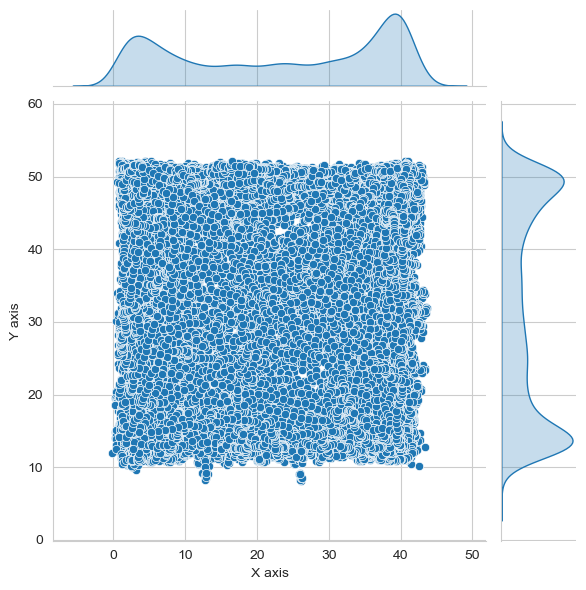

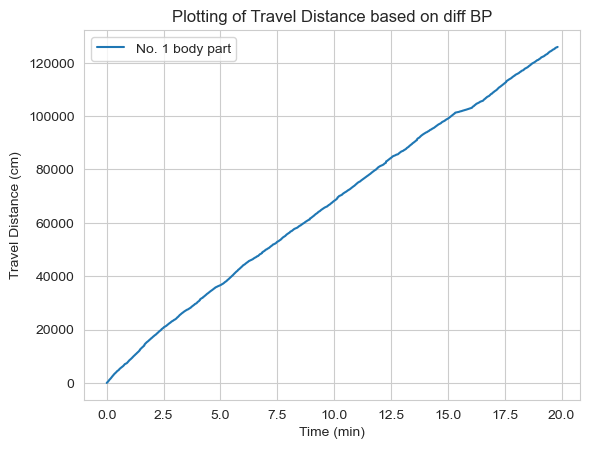

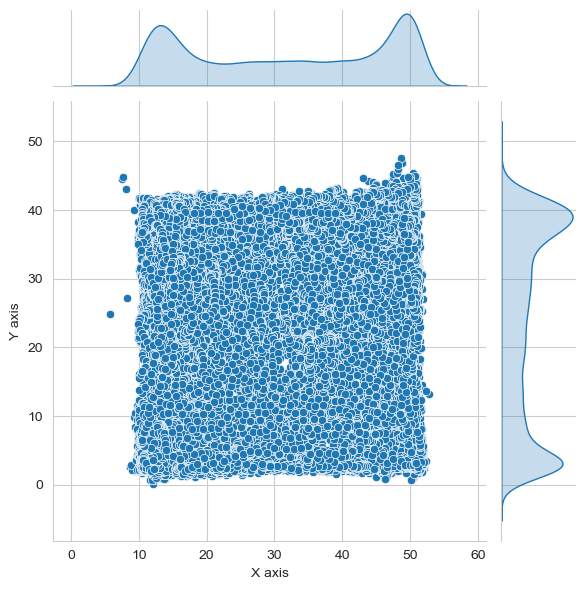

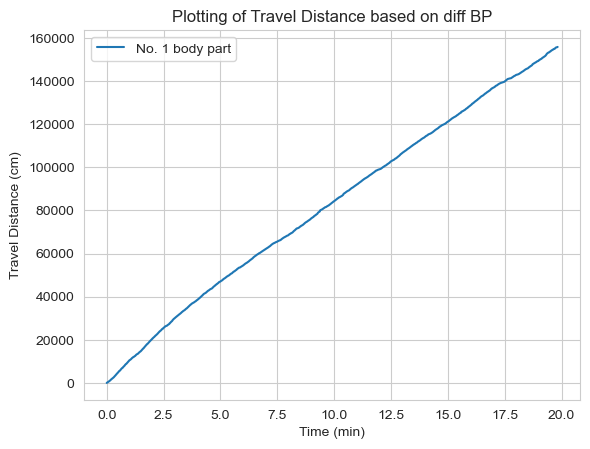

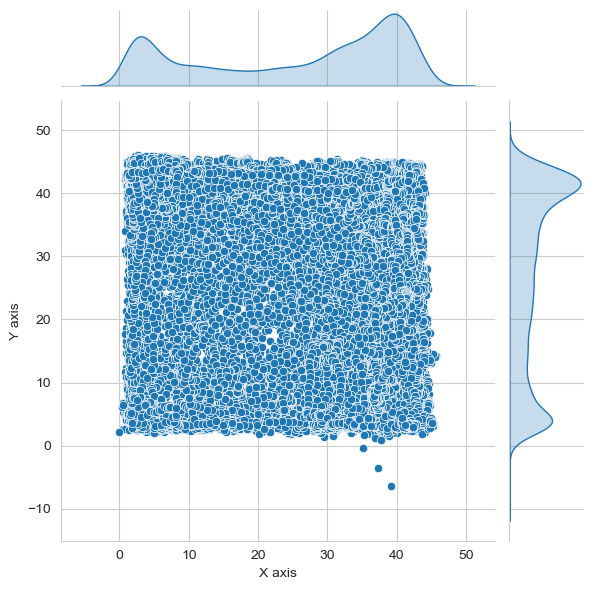

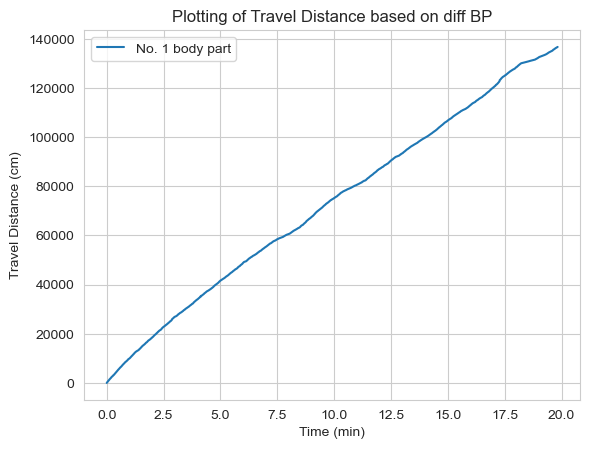

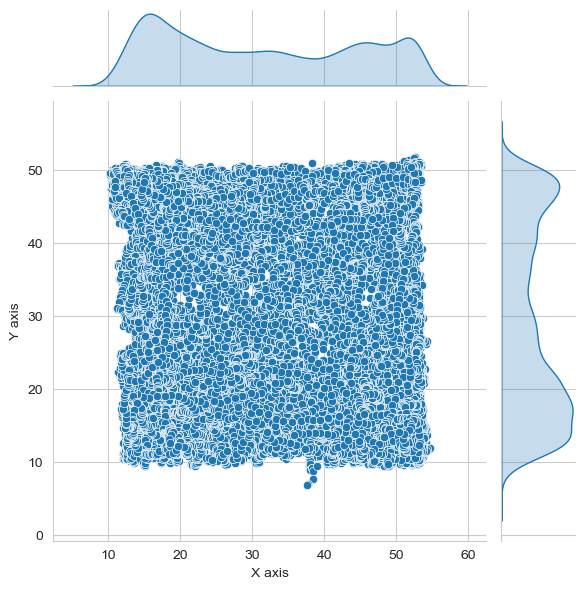

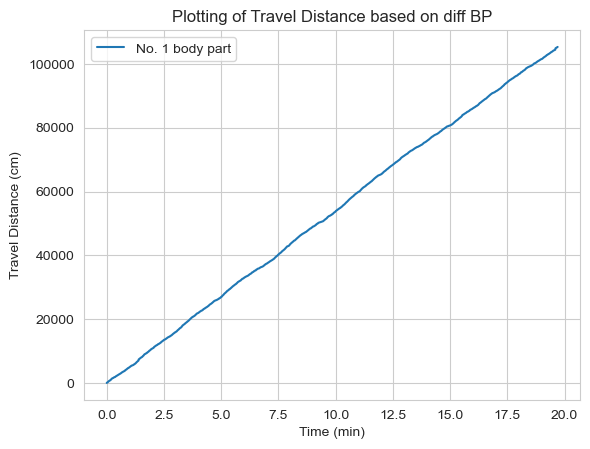

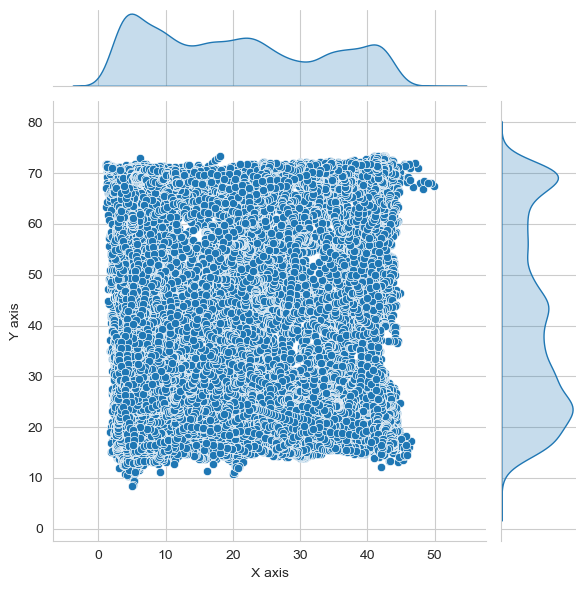

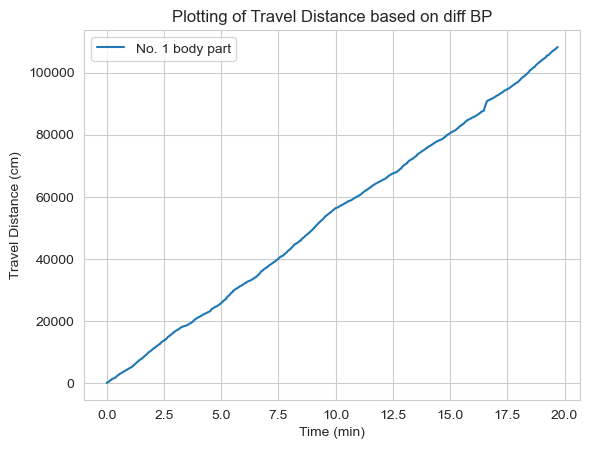

In [65]:


# videoname = input('Enter video title: (Without extension)')
file = r"/Users/arthur/Behavior/FAD1114_filtered/"
# videoname = input('Enter video title: (Without extension) to start the program')
# while videoname:
for videoname in filels:


    csv_ls = read_filtered_csv(file, videoname=videoname)


    TopL,BottomR, dur= get_video_info(data=data, video=videoname)

    #image_calibration
    BottomR = eval(BottomR)
    TopL = eval(TopL)
    dur = float(dur)
    # TopL
    CalX = (BottomR[0]-TopL[0])/BoxL
    CalY = (BottomR[1]-TopL[1])/BoxL
    XY0 = [TopL[0]/CalX, TopL[1]/CalY]



    filtered_path = read_filtered_csv(dir_name=file,videoname=videoname)

    cData,fLs, Time = process(filtered_path,dur)
    cal_speed_dis(cData,ratiox=CalX, ratioy=CalY,dur=dur)
    cal_cumsum_dist(cData,CalX, CalY,Time)
    output = edge_prefer(fLs, cData)

    print('output ==', output.head())
#     videoname = input('Enter video name / End to exit')

In [63]:
filels.remove('TR F FAD+_OF')

In [66]:
output.to_csv('./outut_all.csv')

In [64]:
filels

['FAD01_OF',
 'FAD02_OF',
 'FAD03_OF',
 'FAD04_OF',
 'FAD09_remapped',
 'FAD10_remapped',
 'FAD11_remapped',
 'FAD13_remapped',
 'FAD15_remapped',
 'FAD17_OF',
 'FAD18_OF',
 'FAD19_OF',
 'FAD20_OF',
 'TL M FAD-_OF',
 'TR M FAD+_OF']